<a href="https://colab.research.google.com/github/shghatge/pointnet/blob/master/Copy_of_feat_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk 
from nltk import word_tokenize
from nltk.util import ngrams
import pickle
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [0]:
def dump_to_file(obj, file):
    f = open(file,"wb")
    pickle.dump(obj,f)
    f.close()
def get_obj(file):
    with open(file, 'rb') as handle:
        obj = pickle.load(handle)
    return obj
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems
  

In [3]:
trainFile = pd.read_csv('TopTenTrain2.csv', low_memory=False)
testFile = pd.read_csv('TopTenTest2.csv', low_memory=False)
print('Data Read')

Data Read


In [4]:
print(trainFile["cleanText"][108])
print(trainFile["text"][108])
print(trainFile["fillers"][108])

Our state doesnt yet, say that 
Our state doesn't yet, <laughter> say that  /
None


In [5]:
train_corpus_file = 'train_corpus.pkl'
test_corpus_file = 'test_corpus.pkl'
train_corpus = get_obj(train_corpus_file)
test_corpus = get_obj(test_corpus_file)
print(train_corpus[:10])

FileNotFoundError: ignored

In [0]:
pos_dict = dict()
labels_dict = dict()
#nltk.download('averaged_perceptron_tagger')
for index , row in trainFile.iterrows():
    tokens = nltk.word_tokenize(row['cleanText'])
    tagged = nltk.pos_tag(tokens)
    l=[]
    for tag in tagged:
      l.append(tag[0])
      l.append(tag[1])
    pos_dict[index] = " ".join(l)
    labels_dict[index] = row['act_tag']

In [0]:
pos_dict_test = dict()
labels_dict_test = dict()
#nltk.download('averaged_perceptron_tagger')
for index , row in testFile.iterrows():
    tokens = nltk.word_tokenize(row['cleanText'])
    tagged = nltk.pos_tag(tokens)
    l=[]
    for tag in tagged:
      l.append(tag[0])
      l.append(tag[1])
    pos_dict_test[index] = " ".join(l)
    labels_dict_test[index] = row['act_tag']

In [0]:
corpus=list(pos_dict.values())

In [9]:
vectorizer = CountVectorizer(tokenizer = tokenize, min_df=30, max_df=1000000)
vectorizer.fit(corpus)
vocab = list(vectorizer.vocabulary_.keys())
print(len(vectorizer.stop_words_))
print(vocab)

9568
['doe', 'vbz', 'it', 'prp', 'say', 'vb', 'someth', 'nn', '?', '.', 'i', 'think', 'vbp', 'usual', 'rb', 'okay', 'well', ',', 'seem', 'vbd', 'like', 'in', 'did', 'but', 'cc', 'might', 'md', 'not', 'guess', 'uh', 'my', '$', 'sister', 'ha', 'a', 'dt', 'she', 'just', 'had', 'babi', 'he', 'about', 'five', 'cd', 'month', 'old', 'jj', 'and', 'wa', 'worri', 'vbg', 'go', 'back', 'to', 'work', 'what', 'wp', 'do', 'with', 'him', 'nnp', 'huh', 'you', 'have', 'kid', 'yeah', 'ye', 'dont', 'though', 'use', 'when', 'wrb', 'two', 'children', 'off', 'on', 'find', 'friend', 'anybodi', 'who', 'that', 'situat', 'day', 'care', 'your', 'live', 'big', 'commun', 'fairli', 'larg', 'got', 'real', 'lucki', 'boss', 'move', 'into', 'larger', 'jjr', 'offic', 'abl', 'take', 'her', 'small', 'legal', 'firm', 'one', 'lawyer', 'um', 'so', 'the', 'onli', 'realli', 'of', 'there', 'no', 'els', 'ex', 'they', 'an', 'extra', 'room', 'everyth', 'for', 'out', 'rp', 'pretti', 'good', 'wow', 'how', 'know', 'lot', 'peopl', 'aro

In [10]:
le = preprocessing.LabelEncoder()
le.fit(vocab)

LabelEncoder()

In [0]:
import bisect
test_rows = dict()
i=0
le_classes = le.classes_.tolist()
bisect.insort_left(le_classes, 'otherClass')
le.classes_ = le_classes
for index, row in testFile.iterrows():
  test = ['otherClass' if s not in le.classes_ else s for s in tokenize(pos_dict_test[index].lower())]
  test_rows[index] = le.transform(test)
X_test = pad_sequences(list(test_rows.values()), maxlen=100)

In [0]:
features_rows = dict()
for index , row in trainFile.iterrows():
  test = ['otherClass' if s not in le.classes_ else s for s in tokenize(pos_dict[index].lower())]
  features_rows[index] = le.transform(test)

In [0]:
features = list(features_rows.values())
padded = pad_sequences(features, maxlen=100)

In [16]:
enc = preprocessing.LabelEncoder()
enc.fit(np.array([*labels_dict.values()]))

LabelEncoder()

In [0]:
y = enc.transform(np.array([*labels_dict.values()]))
y_test = enc.transform(np.array([*labels_dict_test.values()]))

In [0]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=15 )).fit(padded, y)

In [0]:
preds = model.predict(X_test)

In [20]:
target_names = enc.classes_
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

           %       0.69      0.72      0.70      2440
          aa       0.39      0.40      0.40       859
           b       0.85      0.94      0.89      6157
          ba       0.81      0.47      0.60       756
          fc       0.98      0.49      0.65       391
          ny       0.47      0.06      0.11       413
          qy       0.95      0.70      0.80       516
          sd       0.68      0.95      0.79     10287
          sv       0.52      0.02      0.04      4152
           x       0.99      1.00      1.00       569

   micro avg       0.73      0.73      0.73     26540
   macro avg       0.73      0.58      0.60     26540
weighted avg       0.70      0.73      0.66     26540



Confusion matrix, without normalization
[[1764   18  199    4    0    6    2  441    6    0]
 [  44  342  392    9    0    2    1   58   11    0]
 [  98  196 5801   25    1   18    1   14    1    2]
 [  30  191   27  359    0    3    0  125   21    0]
 [  19    4   85    2  190    0    1   90    0    0]
 [  20   34  333    0    0   26    0    0    0    0]
 [  23    1    1    0    1    0  360  128    2    0]
 [ 390   41   19   12    1    0   11 9774   39    0]
 [ 178   42    4   32    0    0    3 3805   87    1]
 [   0    0    0    0    0    0    0    1    1  567]]
Normalized confusion matrix
[[7.23e-01 7.38e-03 8.16e-02 1.64e-03 0.00e+00 2.46e-03 8.20e-04 1.81e-01
  2.46e-03 0.00e+00]
 [5.12e-02 3.98e-01 4.56e-01 1.05e-02 0.00e+00 2.33e-03 1.16e-03 6.75e-02
  1.28e-02 0.00e+00]
 [1.59e-02 3.18e-02 9.42e-01 4.06e-03 1.62e-04 2.92e-03 1.62e-04 2.27e-03
  1.62e-04 3.25e-04]
 [3.97e-02 2.53e-01 3.57e-02 4.75e-01 0.00e+00 3.97e-03 0.00e+00 1.65e-01
  2.78e-02 0.00e+00]
 [4.86e-02 1.02e-02 2

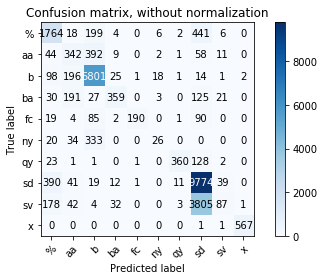

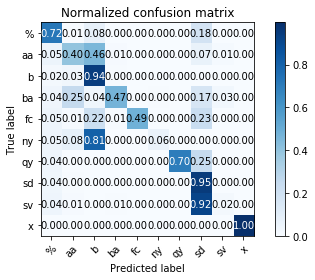

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, preds, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, preds, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [33]:
headers = []
for i in range(50,0,-1):
  headers.append('enc_pos_'+str(i))
  headers.append('enc_word_'+str(i))
print(headers)

['enc_pos_50', 'enc_word_50', 'enc_pos_49', 'enc_word_49', 'enc_pos_48', 'enc_word_48', 'enc_pos_47', 'enc_word_47', 'enc_pos_46', 'enc_word_46', 'enc_pos_45', 'enc_word_45', 'enc_pos_44', 'enc_word_44', 'enc_pos_43', 'enc_word_43', 'enc_pos_42', 'enc_word_42', 'enc_pos_41', 'enc_word_41', 'enc_pos_40', 'enc_word_40', 'enc_pos_39', 'enc_word_39', 'enc_pos_38', 'enc_word_38', 'enc_pos_37', 'enc_word_37', 'enc_pos_36', 'enc_word_36', 'enc_pos_35', 'enc_word_35', 'enc_pos_34', 'enc_word_34', 'enc_pos_33', 'enc_word_33', 'enc_pos_32', 'enc_word_32', 'enc_pos_31', 'enc_word_31', 'enc_pos_30', 'enc_word_30', 'enc_pos_29', 'enc_word_29', 'enc_pos_28', 'enc_word_28', 'enc_pos_27', 'enc_word_27', 'enc_pos_26', 'enc_word_26', 'enc_pos_25', 'enc_word_25', 'enc_pos_24', 'enc_word_24', 'enc_pos_23', 'enc_word_23', 'enc_pos_22', 'enc_word_22', 'enc_pos_21', 'enc_word_21', 'enc_pos_20', 'enc_word_20', 'enc_pos_19', 'enc_word_19', 'enc_pos_18', 'enc_word_18', 'enc_pos_17', 'enc_word_17', 'enc_pos_16',

In [0]:
out_x = np.vstack((headers, padded))

In [35]:
print(len(out_x))

147511


In [0]:
pdf = pd.DataFrame(data=padded,columns = headers) 
pdf.to_csv('POS_WORD_FEATURES')